In [3]:
%pip install llama-index-llms-openai llama-index-experimental

Note: you may need to restart the kernel to use updated packages.


In [4]:
from llama_index.core.query_pipeline import (
    QueryPipeline as QP,
    Link,
    InputComponent,
)
from llama_index.experimental.query_engine.pandas import (
    PandasInstructionParser,
)
from llama_index.llms.openai import OpenAI
from llama_index.core import PromptTemplate

In [18]:
import pandas as pd

df = pd.read_csv("Data.csv")

In [19]:
instruction_str = (
    "1. Convert the query to executable Python code using Pandas.\n"
    "2. The final line of code should be a Python expression that can be called with the `eval()` function.\n"
    "3. The code should represent a solution to the query.\n"
    "4. PRINT ONLY THE EXPRESSION.\n"
    "5. Do not quote the expression.\n"
)

pandas_prompt_str = (
    "You are working with a pandas dataframe in Python.\n"
    "The name of the dataframe is `df`.\n"
    "This is the result of `print(df.head())`:\n"
    "{df_str}\n\n"
    "Follow these instructions:\n"
    "{instruction_str}\n"
    "Query: {query_str}\n\n"
    "Expression:"
)
response_synthesis_prompt_str = (
    "Given an input question, synthesize a response from the query results.\n"
    "Query: {query_str}\n\n"
    "Pandas Instructions (optional):\n{pandas_instructions}\n\n"
    "Pandas Output: {pandas_output}\n\n"
    "Response: "
)

pandas_prompt = PromptTemplate(pandas_prompt_str).partial_format(
    instruction_str=instruction_str, df_str=df.head(5)
)
pandas_output_parser = PandasInstructionParser(df)
response_synthesis_prompt = PromptTemplate(response_synthesis_prompt_str)
llm = OpenAI(model="gpt-3.5-turbo")

In [20]:
qp = QP(
    modules={
        "input": InputComponent(),
        "pandas_prompt": pandas_prompt,
        "llm1": llm,
        "pandas_output_parser": pandas_output_parser,
        "response_synthesis_prompt": response_synthesis_prompt,
        "llm2": llm,
    },
    verbose=False,
)
qp.add_chain(["input", "pandas_prompt", "llm1", "pandas_output_parser"])
qp.add_links(
    [
        Link("input", "response_synthesis_prompt", dest_key="query_str"),
        Link(
            "llm1", "response_synthesis_prompt", dest_key="pandas_instructions"
        ),
        Link(
            "pandas_output_parser",
            "response_synthesis_prompt",
            dest_key="pandas_output",
        ),
    ]
)
# add link from response synthesis prompt to llm2
qp.add_link("response_synthesis_prompt", "llm2")

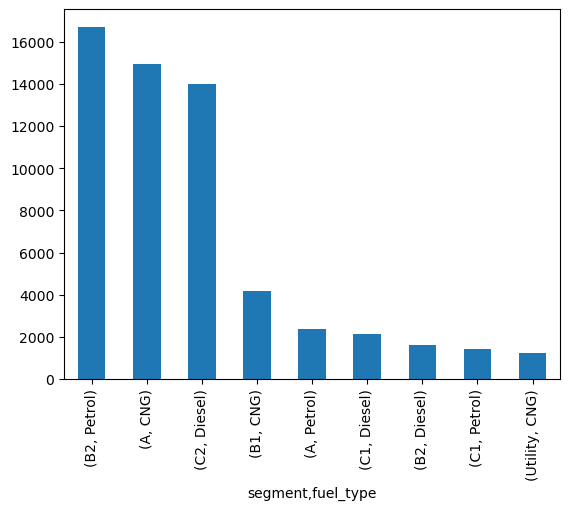

In [28]:
response = qp.run(
    query_str="can you create a bar chart to show top 10 car models group by segment and fuel_type",
)

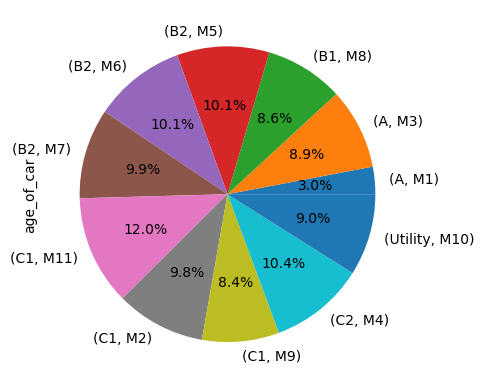

In [32]:
response = qp.run(
    query_str="Can you group the Segment and model and show me age of car in pie chart. please display percentage too",
)